# Robustness to control variation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [4]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_ctrl_size/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [8]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

### Experiment set-up

```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/3_ctrl_size_analysis
outdir=/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/

for p in $(cat /lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
    for d in ACR AR CR; do
        echo "python run_oor_design.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${p} ${d} --outpath ${outdir}" | \
            bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done

## To merge results

awk '(NR == 1) || (FNR > 1)' ${outdir}/*/ctrl_size_analysis_nquery7/*/*_*_results.csv > ${outdir}/ctrl_size_nquery7_results.csv
awk '(NR == 1) || (FNR > 1)' ${outdir}/*/ctrl_size_analysis_nquery5/*/*_*_results.csv > ${outdir}/ctrl_size_nquery5_results.csv
awk '(NR == 1) || (FNR > 1)' ${outdir}/*/ctrl_size_analysis_nquery9/*/*_*_results.csv > ${outdir}/ctrl_size_nquery9_results.csv
```


In [11]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'

res_all_df = pd.DataFrame()
for n_q in [5, 7, 9]:
    res_df = pd.read_csv(outdir + f'ctrl_size_nquery{n_q}_results.csv', index_col=0)
    res_df['n_querys'] = n_q
    res_all_df = pd.concat([res_all_df, res_df])
old_code = False

In [15]:
%%R -i res_all_df
head(res_all_df)

  TP FP FN   TN       TPR         FPR       FDR     AUPRC no_skill_thresh
1 17  4 17 1179 0.5000000 0.003381234 0.1904762 0.7740276      0.02793755
2  0  0 37 1112 0.0000000 0.000000000 0.0000000 0.7540411      0.03220191
3 16  0 13 1150 0.5517241 0.000000000 0.0000000 0.9170340      0.02459712
4  6  2 32 1074 0.1578947 0.001858736 0.2500000 0.6108111      0.03411131
5  7  0 21 1080 0.2500000 0.000000000 0.0000000 0.9114950      0.02527076
6 11  0 19 1092 0.3666667 0.000000000 0.0000000 0.8415225      0.02673797
                        OOR_state n_ctrls random_seed ref_design emb_method
1 CD14_low_CD16_positive_monocyte      10       12345        ACR   scArches
2 CD14_low_CD16_positive_monocyte      10       12345         CR   scArches
3 CD14_low_CD16_positive_monocyte      10       12345         CR       scVI
4 CD14_low_CD16_positive_monocyte      10       12346        ACR   scArches
5 CD14_low_CD16_positive_monocyte      10       12346         CR   scArches
6 CD14_low_CD16_positive_m

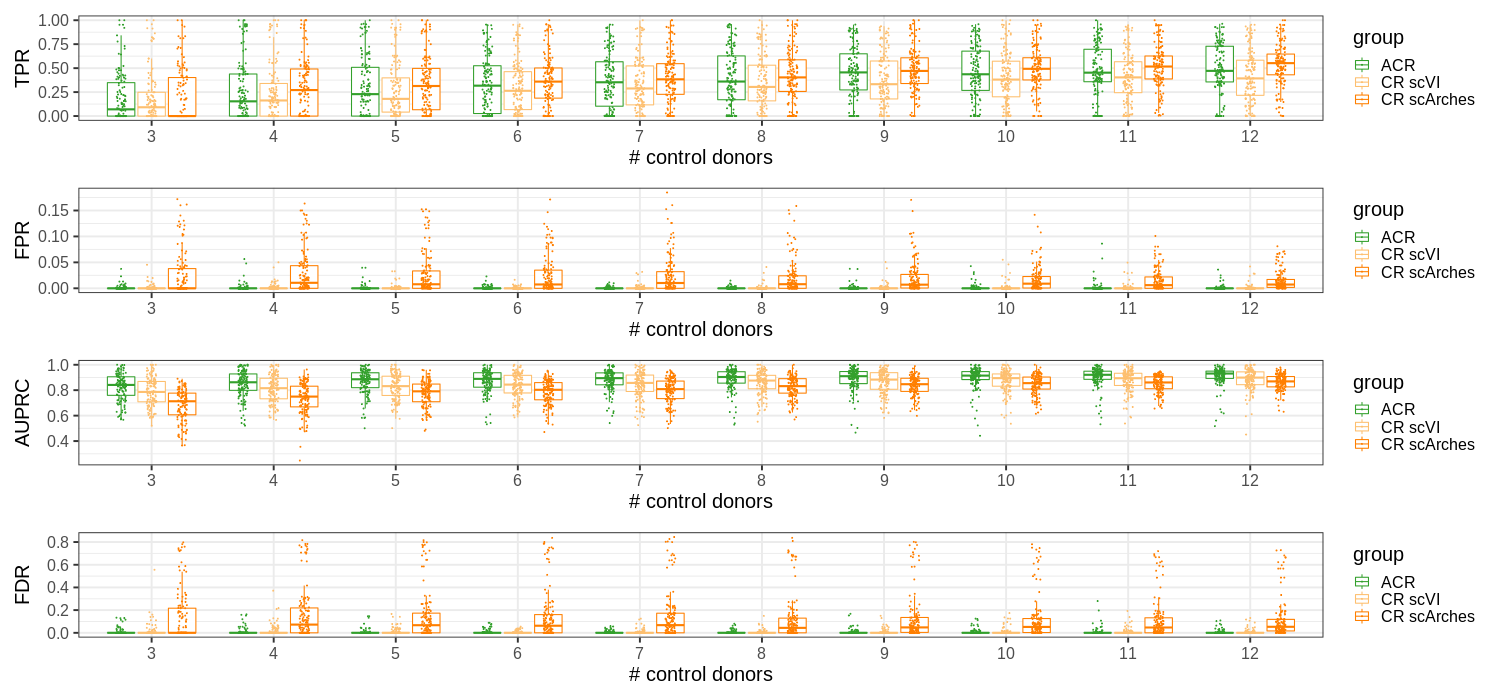

In [16]:
%%R -w 1500 -h 700 -i figdir

pl_df <- res_all_df %>%
    filter(OOR_state != 'CD14_low_CD16_positive_monocyte') %>%
    mutate(OOR_state = factor(OOR_state, levels=unique(OOR_state)))
    
pl_ls <- lapply(c('TPR', "FPR", 'AUPRC', 'FDR'), function(m) {
    pl_df %>%
    rename(metric = m) %>%
    mutate(group=ifelse(ref_design == 'CR', paste(ref_design, emb_method), ref_design)) %>%
    mutate(group = factor(group, levels=c('ACR', 'CR scVI', 'CR scArches'))) %>%
    ggplot(aes(as.factor(n_ctrls), metric, color=group)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(size=0.3, position=position_jitterdodge(jitter.width=0.2)) +
    theme_bw(base_size=20) +
    ylab(m) +
    scale_color_manual(values=design_palette) +
    xlab('# control donors')} ) 

wrap_plots(pl_ls) +
plot_layout(ncol=1) +
ggsave(paste0(figdir, 'ctrl_size_comparison_new.pdf'), height=20, width=10)

[[1]]

[[2]]

[[3]]

[[4]]



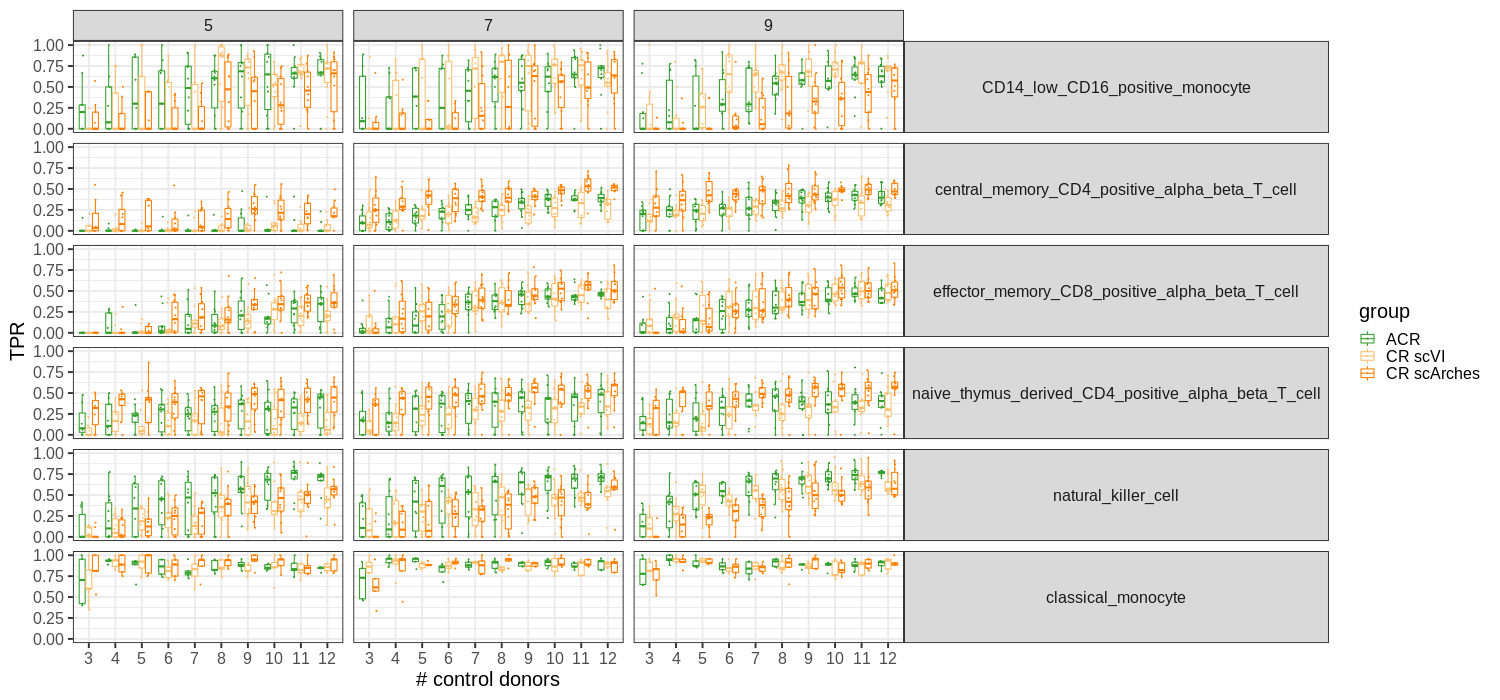

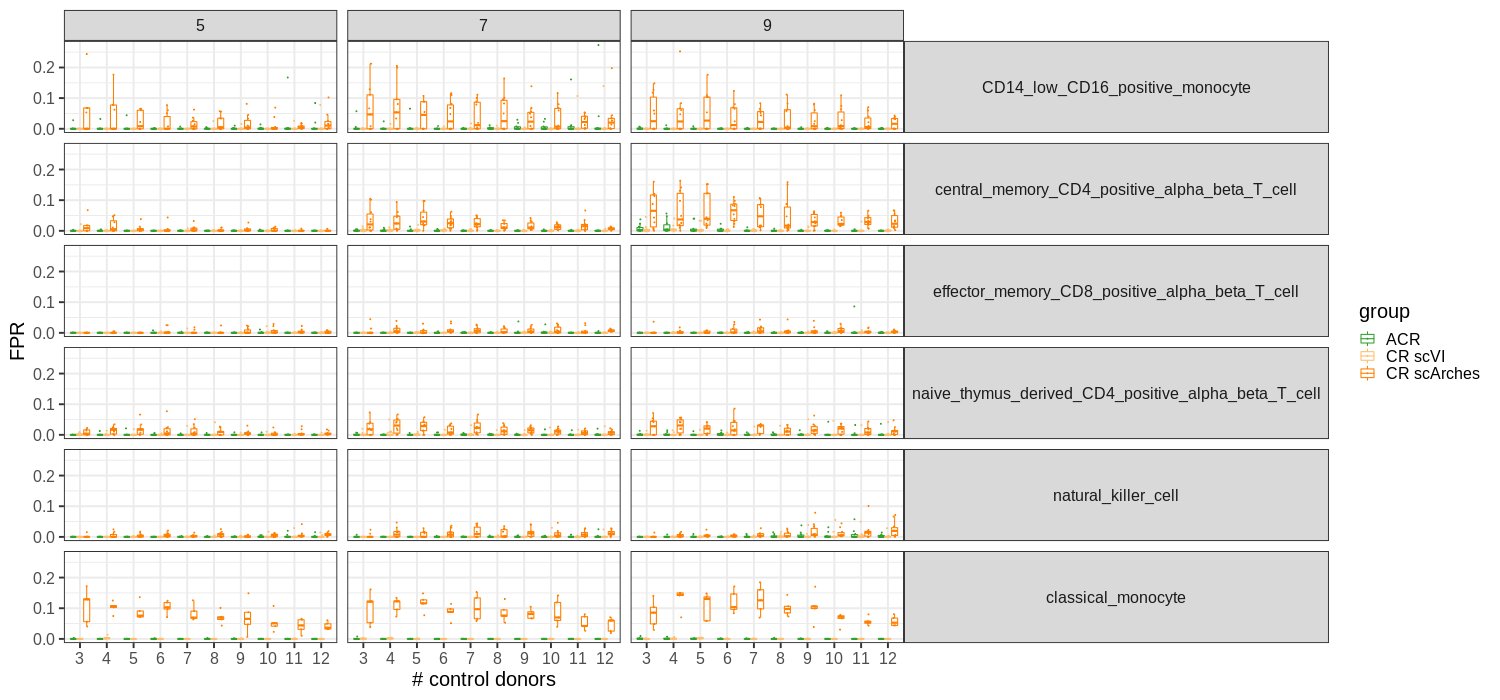

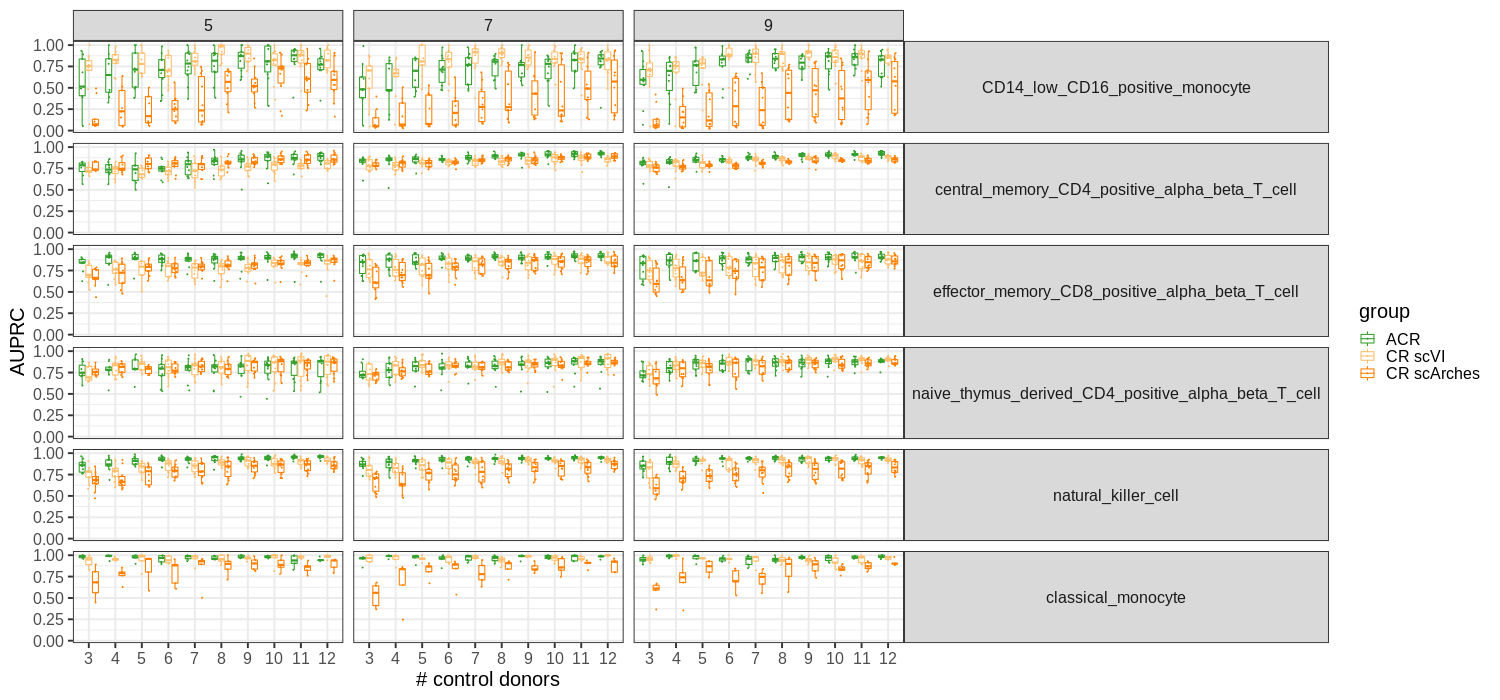

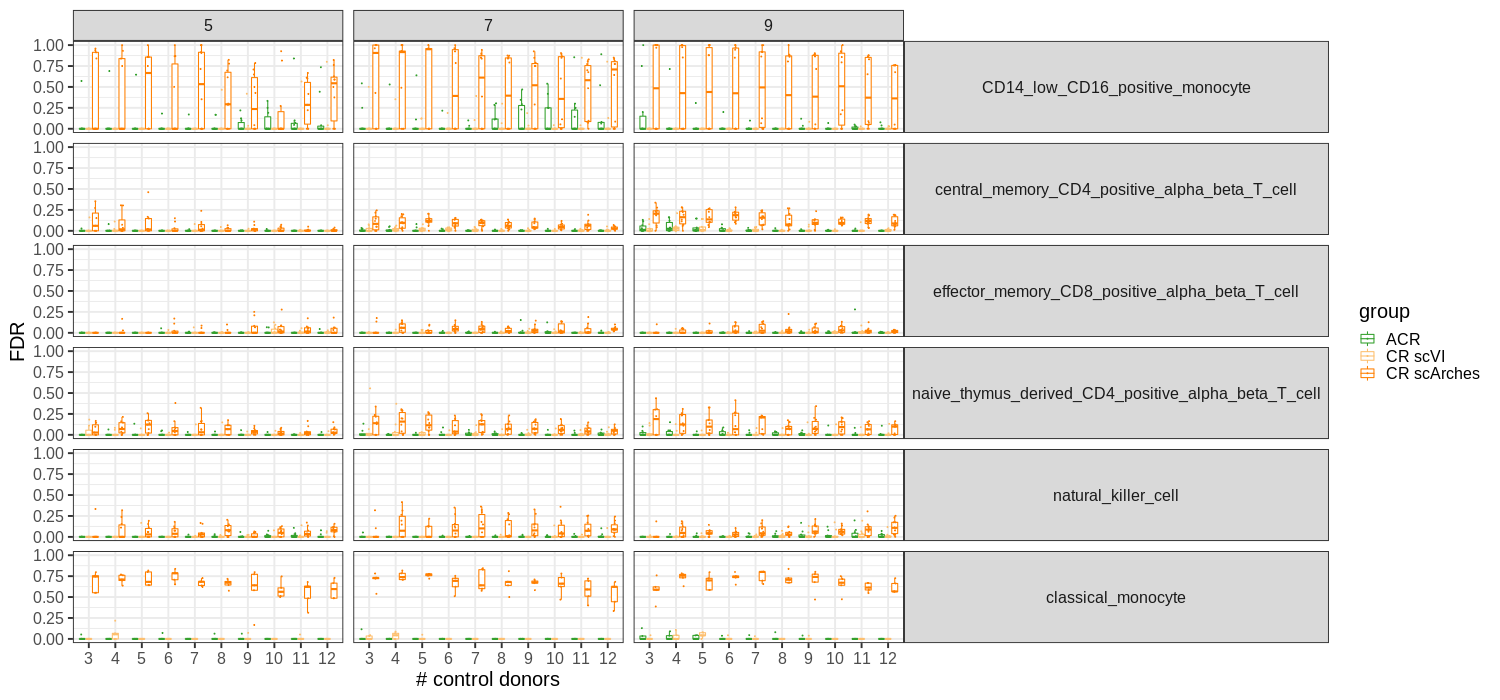

In [253]:
%%R -w 1500 -h 700 -i figdir

pl_df <- res_all_df %>%
    mutate(OOR_state = factor(OOR_state, levels=unique(OOR_state)))
    
# pl_ls <- 
lapply(c('TPR', "FPR", 'AUPRC', 'FDR'), function(m) {
    pl_df %>%
    rename(metric = m) %>%
    mutate(group=ifelse(ref_design == 'CR', paste(ref_design, emb_method), ref_design)) %>%
    mutate(group = factor(group, levels=c('ACR', 'CR scVI', 'CR scArches'))) %>%
    ggplot(aes(as.factor(n_ctrls), metric, color=group)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(size=0.3, position=position_jitterdodge(jitter.width=0.2)) +
    theme_bw(base_size=20) +
    ylab(m) +
    facet_grid(OOR_state~n_querys) +
    scale_color_manual(values=design_palette) +
    xlab('# control donors') +
    theme(strip.text.y=element_text(angle=0)) +
    ggsave(paste0(figdir, m,'_ctrl_size_comparison_new_facets.pdf'), height=15, width=19)
} ) 

# wrap_plots(pl_ls) +
# plot_layout(ncol=1) +
# ggsave(paste0(figdir, 'ctrl_size_comparison_new_facets.pdf'), height=40, width=10)

#### Run t-tests

In [47]:
%%R
res_all_df %>%
filter(n_querys == 7) %>%
filter(OOR_state != 'CD14_low_CD16_positive_monocyte') %>%
mutate(group = paste(ref_design, emb_method)) %>%
group_by(n_ctrls, group) %>%
summarise(value=list(AUPRC)) %>%
spread(group, value) %>%
mutate(
    p_value_vs_scarches =  t.test(unlist(`ACR scArches`), unlist(`CR scArches`), alternative='greater')$p.value,
    p_value_vs_scvi =  t.test(unlist(`ACR scArches`), unlist(`CR scVI`), alternative='greater')$p.value
      ) %>%
select(n_ctrls, p_value_vs_scvi, p_value_vs_scarches)

`summarise()` has grouped output by 'n_ctrls'. You can override using the
`.groups` argument.
# A tibble: 10 × 3
# Groups:   n_ctrls [10]
   n_ctrls p_value_vs_scvi p_value_vs_scarches
     <int>           <dbl>               <dbl>
 1       3          0.107         0.0000000268
 2       4          0.0550        0.00000675  
 3       5          0.0476        0.000000328 
 4       6          0.0417        0.0000176   
 5       7          0.0164        0.00000295  
 6       8          0.0210        0.00000688  
 7       9          0.0526        0.0000876   
 8      10          0.0645        0.000225    
 9      11          0.0444        0.0000770   
10      12          0.0636        0.000270    


In [38]:
%%R
res_all_df %>%
# filter(n_ctrls < 10) %>%
filter(OOR_state != 'CD14_low_CD16_positive_monocyte') %>%
mutate(group = paste(ref_design, emb_method)) %>%
distinct(AUPRC, OOR_state, group, n_ctrls) %>%
group_by( group) %>%
# summarise(value=list(AUPRC)) %>%
# spread(group, value) %>%
summarise(cor = Hmisc::rcorr(n_ctrls, AUPRC)$P
#     cor_vs_scarches =  cor(unlist(`ACR scArches`), unlist(`CR scArches`), alternative='greater')$p.value,
#     p_value_vs_scvi =  t.test(unlist(`ACR scArches`), unlist(`CR scVI`), alternative='greater')$p.value
      ) 


`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
# A tibble: 6 × 2
# Groups:   group [3]
  group        cor[,1]  [,2]
  <chr>          <dbl> <dbl>
1 ACR scArches      NA     0
2 ACR scArches       0    NA
3 CR scArches       NA     0
4 CR scArches        0    NA
5 CR scVI           NA     0
6 CR scVI            0    NA


In [33]:
%%R
res_all_df %>%
filter(n_ctrls >= 7) %>%
mutate(group = paste(ref_design, emb_method)) %>%
group_by(OOR_state, group) %>%
summarise(value=list(AUPRC)) %>%
spread(group, value) %>%
mutate(
    p_value_vs_scarches =  t.test(unlist(`ACR scArches`), unlist(`CR scArches`), alternative='greater')$p.value,
    p_value_vs_scvi =  t.test(unlist(`ACR scArches`), unlist(`CR scVI`), alternative='greater')$p.value
      ) %>%
select(OOR_state, p_value_vs_scvi, p_value_vs_scarches)

`summarise()` has grouped output by 'OOR_state'. You can override using the
`.groups` argument.
# A tibble: 6 × 3
# Groups:   OOR_state [6]
  OOR_state                                           p_value_vs_scvi p_value_…¹
  <chr>                                                         <dbl>      <dbl>
1 CD14_low_CD16_positive_monocyte                            1.00e+ 0   1.34e-31
2 central_memory_CD4_positive_alpha_beta_T_cell              3.47e-12   1.27e- 7
3 classical_monocyte                                         1.37e- 1   4.05e-17
4 effector_memory_CD8_positive_alpha_beta_T_cell             3.76e-14   1.37e-15
5 naive_thymus_derived_CD4_positive_alpha_beta_T_cell        9.92e- 1   7.93e- 1
6 natural_killer_cell                                        2.08e-14   2.12e-39
# … with abbreviated variable name ¹​p_value_vs_scarches


In [226]:
%%R -o out_model
out_model <- res_all_df %>%
mutate(group = paste(OOR_state, ref_design, emb_method)) %>%
group_by(group) %>%
do(model = lm(AUPRC ~ n_ctrls, data = .)) %>%
summarize(broom::tidy(model))  %>%
filter(term == 'n_ctrls')

out_names <- res_all_df %>%
mutate(group = paste(OOR_state, ref_design, emb_method)) %>%
distinct(group) 

out_model <- out_model %>%
    mutate(names=out_names[['group']])
# summarise(
#     cor=Hmisc::rcorr(AUPRC, n_ctrls, type='spearman')$r[[2]],
#     cor_pval=Hmisc::rcorr(AUPRC, n_ctrls, type='spearman')$P[[2]]
#          )
# ggplot(aes(OOR_state, group, size=cor, color=cor)) +
# geom_point() +
# scale_color_viridis_c() +
# scale_size(range=c(0,10))


In [228]:
out_model

,term,estimate,std.error,statistic,p.value,names
1,n_ctrls,0.023979,0.003864,6.206279,1.855722e-09,CD14_low_CD16_positive_monocyte ACR scArches
2,n_ctrls,0.048807,0.004848,10.067225,1.168147e-20,CD14_low_CD16_positive_monocyte CR scArches
3,n_ctrls,0.018789,0.003492,5.380084,1.529194e-07,CD14_low_CD16_positive_monocyte CR scVI
4,n_ctrls,0.014674,0.001627,9.018945,2.588363e-17,central_memory_CD4_positive_alpha_beta_T_cell ...
5,n_ctrls,0.011418,0.001024,11.154344,2.643480e-24,central_memory_CD4_positive_alpha_beta_T_cell ...
6,n_ctrls,0.009315,0.001500,6.209834,1.819019e-09,central_memory_CD4_positive_alpha_beta_T_cell ...
7,n_ctrls,0.000247,0.001009,0.244531,8.071583e-01,effector_memory_CD8_positive_alpha_beta_T_cell...
8,n_ctrls,0.025903,0.003603,7.189320,2.986896e-11,effector_memory_CD8_positive_alpha_beta_T_cell...
9,n_ctrls,0.001651,0.001245,1.325461,1.870606e-01,effector_memory_CD8_positive_alpha_beta_T_cell...
10,n_ctrls,0.008670,0.001570,5.520474,7.414049e-08,naive_thymus_derived_CD4_positive_alpha_beta_T...


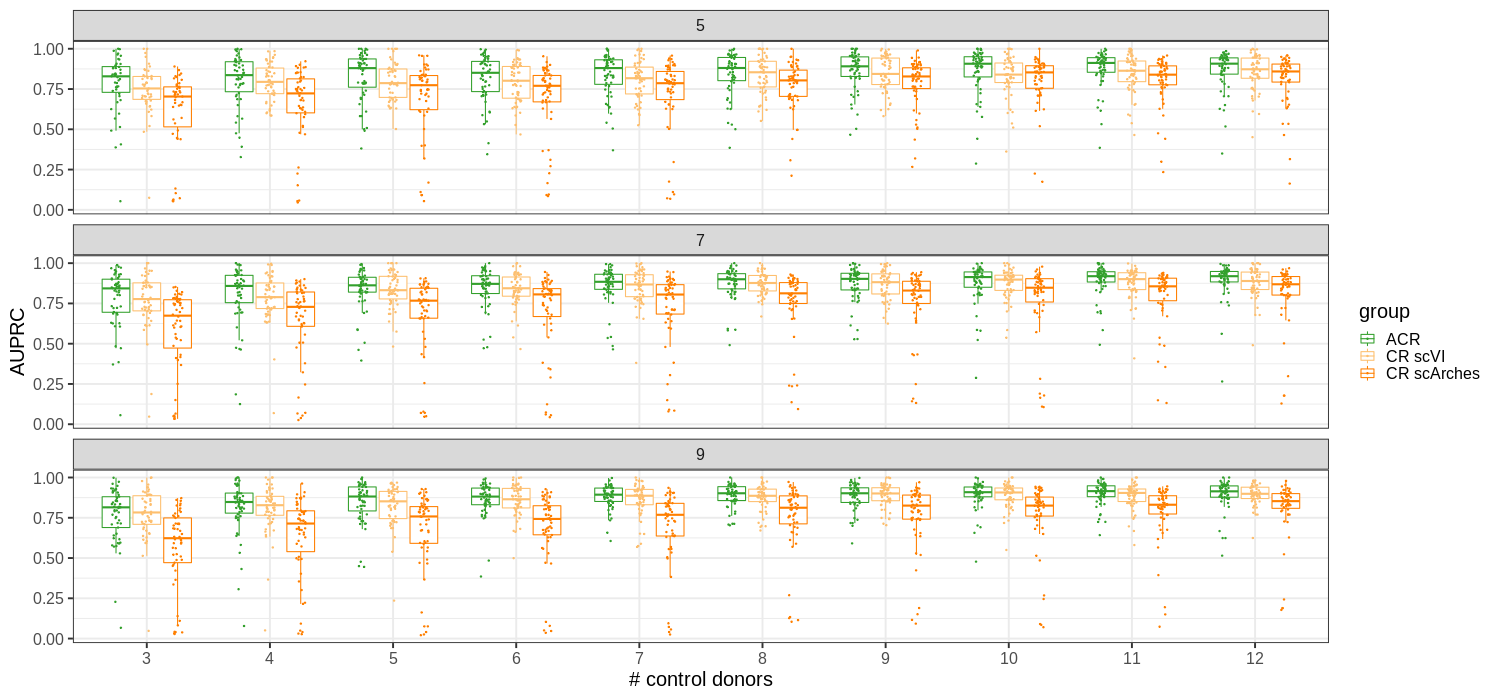

In [108]:
%%R -w 1500 -h 700

pl_df <- res_all_df %>%
    mutate(OOR_state = factor(OOR_state, levels=unique(OOR_state)))
    
pl_df %>%
    mutate(group=ifelse(ref_design == 'CR', paste(ref_design, emb_method), ref_design)) %>%
    mutate(group = factor(group, levels=c('ACR', 'CR scVI', 'CR scArches'))) %>%
    ggplot(aes(as.factor(n_ctrls), AUPRC, color=group)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(size=0.5, position=position_jitterdodge(jitter.width=0.2)) +
    theme_bw(base_size=20) +
    scale_color_manual(values=design_palette) +
    xlab('# control donors') +
    facet_wrap(n_querys~., nrow=3)